In [37]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'


import sys
sys.path.append('conditional_gan/')

import datetime
import warnings
warnings.filterwarnings('ignore')

In [38]:
import torch.utils.data
import os.path
import random
import torchvision.transforms as transforms
import numpy as np
from numpy import inf
import matplotlib.gridspec as gridspec
import networkx
from skimage.transform import resize
from matplotlib.pyplot import figure
import seaborn as sns


In [3]:
test_data_input = dict(np.load('datasets/livneh/testA.npz'))
test_data_ouput = dict(np.load('datasets/livneh/testB.npz'))

In [4]:
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)

In [5]:
starting_day

datetime.date(2011, 10, 20)

In [6]:
model_path = "conditional_gan/SavedModels/cGanResNoMask"

In [7]:
test_data_input.keys()

['variables', 'data', 'metadata']

In [8]:
test_data_input['data'].shape

(804, 321, 321, 4)

In [9]:
test_data_ouput['data'].shape

(804, 321, 321, 1)

In [10]:
data_A = test_data_input['data']
data_B = test_data_ouput['data']

In [11]:
def take_two_weeks(input_data, start_date):
    return input_data[start_date:start_date + 14, :, :, :]

In [12]:
take_two_weeks(test_data_ouput['data'], 10).shape

(14, 321, 321, 1)

In [13]:
from networks import define_G

In [14]:
model = define_G(3, 1, 32, 'instance', 'resnet', False, [0])
model

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): 

In [15]:
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): 

In [16]:
torch.histc(torch.from_numpy(test_data_ouput['data'][1,:,:,:]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [17]:
figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')

<Figure size 80x80 with 0 Axes>

<Figure size 80x80 with 0 Axes>

In [18]:
#normalizing data
def arr_to_input(arr):
    arr = np.nan_to_num(arr)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=2)
    means = np.nanmean(arr, axis=(0,1,2))
    # scale and shift to [-1,1]
    arr = -1 + 2 * (arr - arr.min((1,2))[:, np.newaxis,np.newaxis]) / (arr.max((1,2))[:, np.newaxis,np.newaxis] - arr.min((1,2))[:, np.newaxis,np.newaxis])
    arr[np.isnan(arr)] = -1; arr[arr == inf] = -1; arr[arr == -inf] = -1
    if 64 is not None:
        new_arr = []
        #print "Resizing data to %d" % 64
        for x in arr:
            new_arr.append(resize(x, (64,64)))
        arr = np.stack(new_arr)
    # convert data from b,0,1,c to b,c,0,1
    arr = np.transpose(arr, (0,3,1,2))
    
    return arr.astype('float32')

In [19]:
def hist_kl_div(tenA, tenB, numbins):
    min_elem = min(torch.min(tenA).item(), torch.min(tenB).item())
    max_elem = max(torch.max(tenA).item(), torch.max(tenB).item())
    #print(min_elem, max_elem)
    histA = torch.histc(tenA.cpu(), numbins, min_elem, max_elem)
    histB = torch.histc(tenB.cpu(), numbins, min_elem, max_elem)
    eps = 1e-4
    histA = (histA+eps)*1.0/torch.sum(histA)
    histB = (histB+eps)*1.0/torch.sum(histB)
    return torch.sum(histA * (torch.log(histA) - torch.log(histB)))

In [20]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [21]:
def plot_histograms(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    
    
    
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im, 1000, None, ec='blue',  histtype='step', label='Real Data')
    ax.hist(fake_im, 1000, None, ec='green',  histtype='step', label='Generated Data')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)
            
#     fig, ax = plt.subplots(nrows=14, ncols=1, figsize=(15, 45))
#     divergences = []
#     for row in ax:
#         colors = ['blue', 'lime']
#         real_im = np.ravel(real_B[curr_day, :,:,:].detach().numpy())
#         fake_im = np.ravel(fake_B[curr_day, :,:,:].detach().numpy())
#         common_params = dict(bins=100, range=(min(np.min(real_im), np.min(fake_im)), max(np.max(real_im), np.max(fake_im))), normed=True, color = colors, label = ['real', 'fake'])
#         #col.title = 'Histograms of Real vs Fake data on day ' + str(start_date + curr_day)
#         row.hist((real_im, fake_im), **common_params)
#         row.legend(prop={'size': 10})

        
#         divergences.append(hist_kl_div(real_B[curr_day, :,:,:].detach(), fake_B[curr_day, :,:,:].detach(), 100))
#         curr_day +=1
    #return divergences

In [39]:
mask = np.load("OceanMask.npy")
mask = resize(mask.astype(np.float), (64,64))
mask[mask == 1] = np.nan
mask = mask + 1

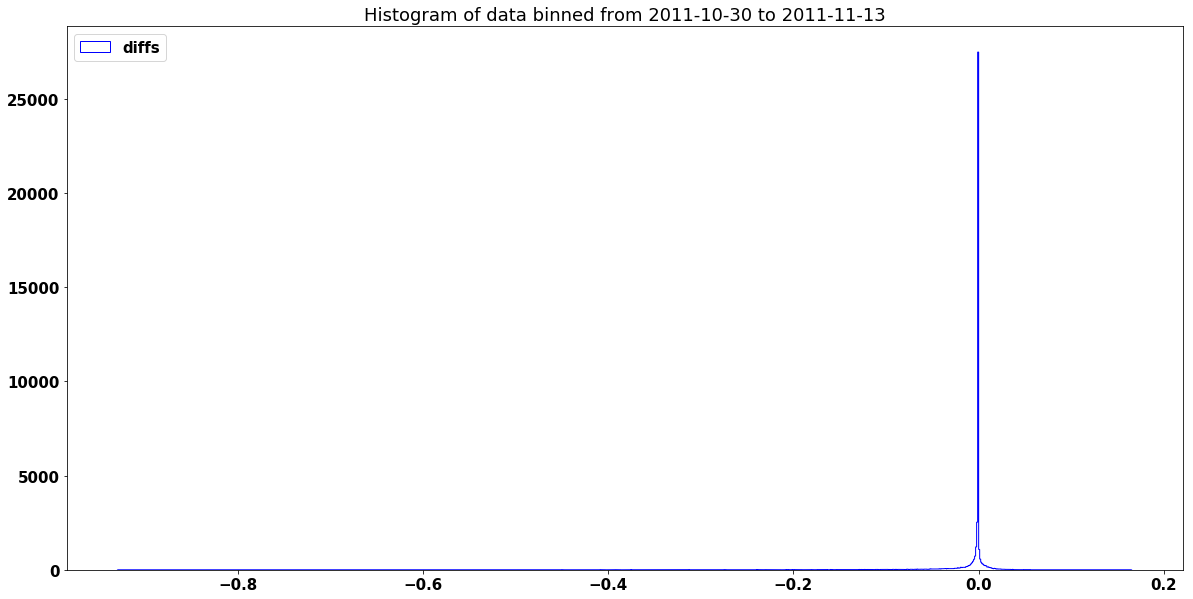

In [40]:
plot_hist_diffs(10, data_A, data_B, mask)

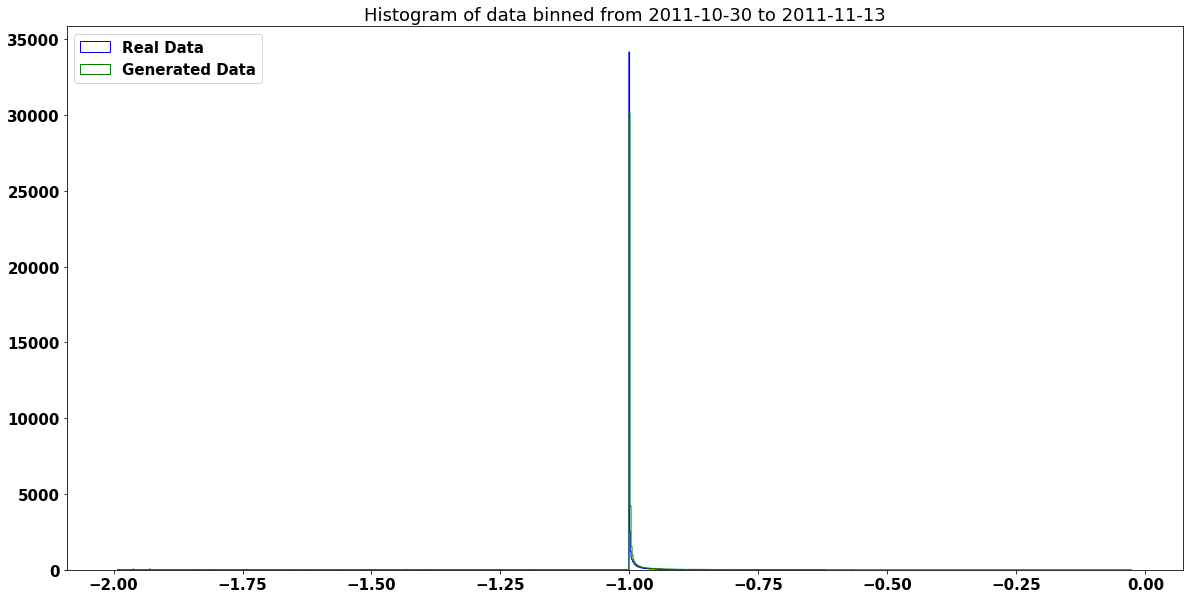

In [41]:
plot_histograms(10, data_A, data_B, mask)

In [42]:
def pearson_coeff(start_date, inputA, inputB):
    fakeB = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).detach().cpu().numpy()
    realB = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date))).numpy()
    
    xbar = np.mean(fakeB, axis=0)
    ybar = np.mean(realB, axis=0)
    xSTDev = np.std(fakeB, axis=0)
    ySTDev = np.std(realB, axis=0)
    r = np.mean(((fakeB - xbar)/(xSTDev)) * ((realB - ybar)/(ySTDev)), axis = 0)
    return r
    

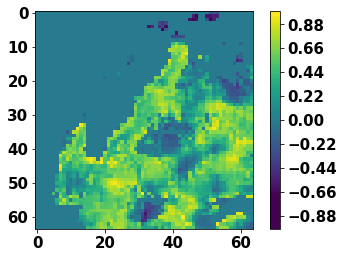

In [43]:
ax = plt.imshow(np.nan_to_num(pearson_coeff(10, data_A, data_B))[0,:,:])
plt.colorbar(ax, boundaries=np.linspace(-1,1,101))


In [44]:
#Making better looking histograms

In [45]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [46]:
def numpy_histograms(start_date, inputA, inputB, zero_mask, num_bins, to_plot = True):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    
    
    mask = np.ravel(np.tile(zero_mask, (real_B.shape[0], 1, 1, 1)))
    
    real_im = np.ravel(real_B.detach().numpy())*(mask/mask)
    fake_im = np.ravel(fake_B.detach().numpy())*(mask/mask)

    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    print(np.mean(real_im))

    
    
    #
    
    #got everything setup, now make bins and counts
    
    real_hist_data = np.histogram(real_im, bins=num_bins)
    fake_hist_data = np.histogram(fake_im, bins=num_bins)
    
    if to_plot:
        fix, ax = plt.subplots(figsize=(10, 10))
        ax.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
        ax.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
        ax.legend(loc='upper right')
        title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_xlabel('Normalized Pixel Values')
        ax.set_ylabel('Log Counts')


    
    return real_hist_data, fake_hist_data


-0.9842912125562963


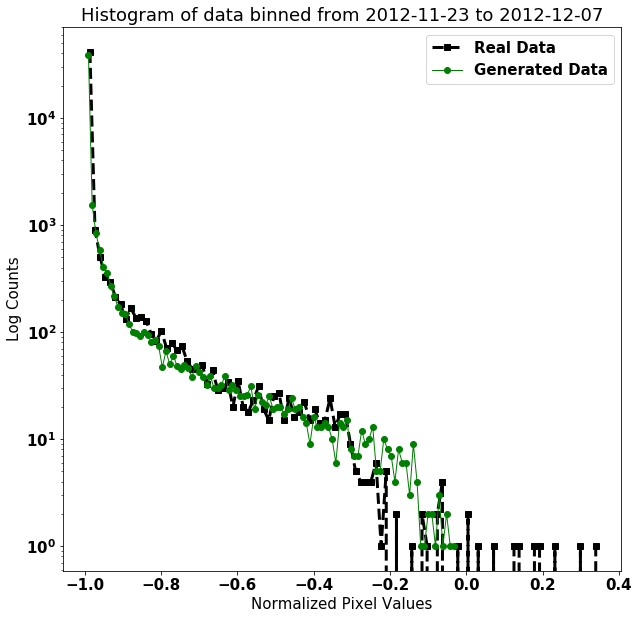

In [47]:
real_hist, fake_hist = numpy_histograms(400, data_A, data_B, mask, 100)

-0.9999349323673736


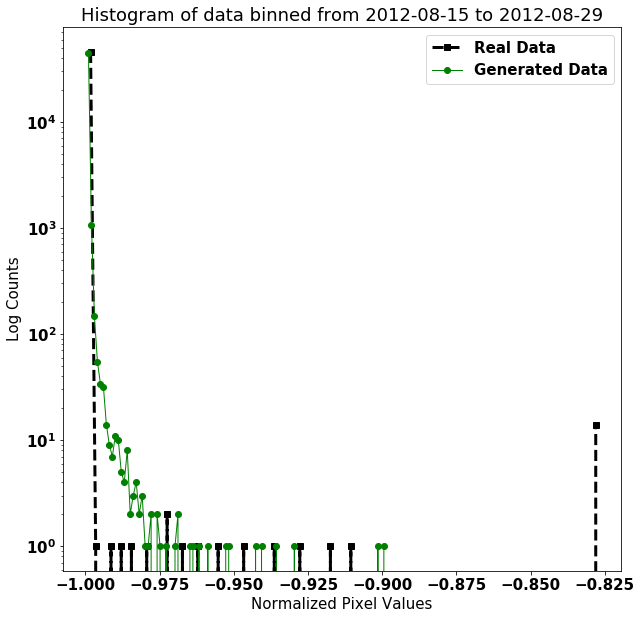

In [48]:
real_hist, fake_hist = numpy_histograms(300, data_A, data_B, mask, 100)

-0.9718666976525545


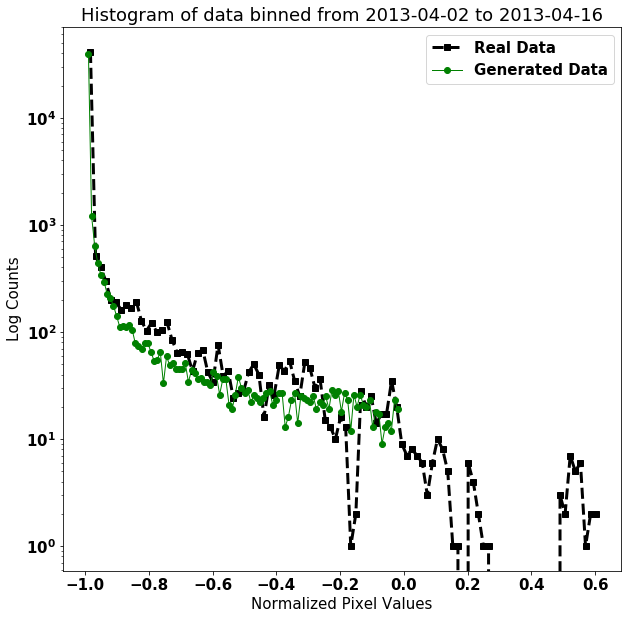

In [49]:
real_hist, fake_hist = numpy_histograms(530, data_A, data_B, mask, 100)

In [50]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

In [51]:
# fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
# real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))

In [62]:
def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,40))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(4, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    ax4 = plt.subplot(gs[1, 0])
    ax5 = plt.subplot(gs[1, 1])
    ax6 = plt.subplot(gs[1, 2])
    
    ax7 = plt.subplot(gs[2, 0:3])
    ax8 = plt.subplot(gs[3, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title(title)
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
    temp = ax4.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap='gray')
    plt.colorbar(temp, ax = ax4, boundaries=np.linspace(-1,1,101))
    ax4.set_title("Correlation Coeffs over " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))

    
    start_date = 400
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    ax2.set_ylabel('Log Counts')
    
    temp = ax5.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax5, boundaries=np.linspace(-1,1,101))
    ax5.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    start_date = 530
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title(title)
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')
    ax3.set_ylabel('Log Counts')
    
    
    temp = ax6.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax6, boundaries=np.linspace(-1,1,101))
    ax6.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    
#     ax8.spy(mask)
#     ax8.set_title("Mask Used for ignoring irrelevant data like ocean")
    num_samples = 10
    
    sampled_input, sampled_output_real = take_n_samples_random(inputA, inputB, num_samples)
    
    sampled_input = torch.from_numpy(arr_to_input(sampled_input)[:,0:3,:,:])
    
    sampled_output_fake = model(sampled_input.cuda()).cpu()
    sampled_output_real = torch.from_numpy(arr_to_input(sampled_output_real))
    #print(sampled_input.shape, sampled_output_fake.shape, sampled_output_real.shape)
    
    
    img = np.hstack([image for image in sampled_input.detach().numpy().reshape(num_samples, 64*3, 64)])
    dx, dy = 64,64

    # Custom (rgb) grid color
    grid_color = 1

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color
    
    ax7.imshow(img)
    ax7.set_ylabel("INPUT CHANNELS: TMIN, TMAX, PRECIPITATION")

    
    
    
    sampled_outputs = torch.cat((sampled_output_fake, sampled_output_real, torch.abs(sampled_output_fake - sampled_output_real)), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 64*3, 64)])

    

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color

    
    
    ax8.imshow(img)
    ax8.set_ylabel("OUTPUTS: ERROR, REAL, GENERATED")
    
    


-0.9999349323673736
-0.9842912125562963
-0.9718666976525545


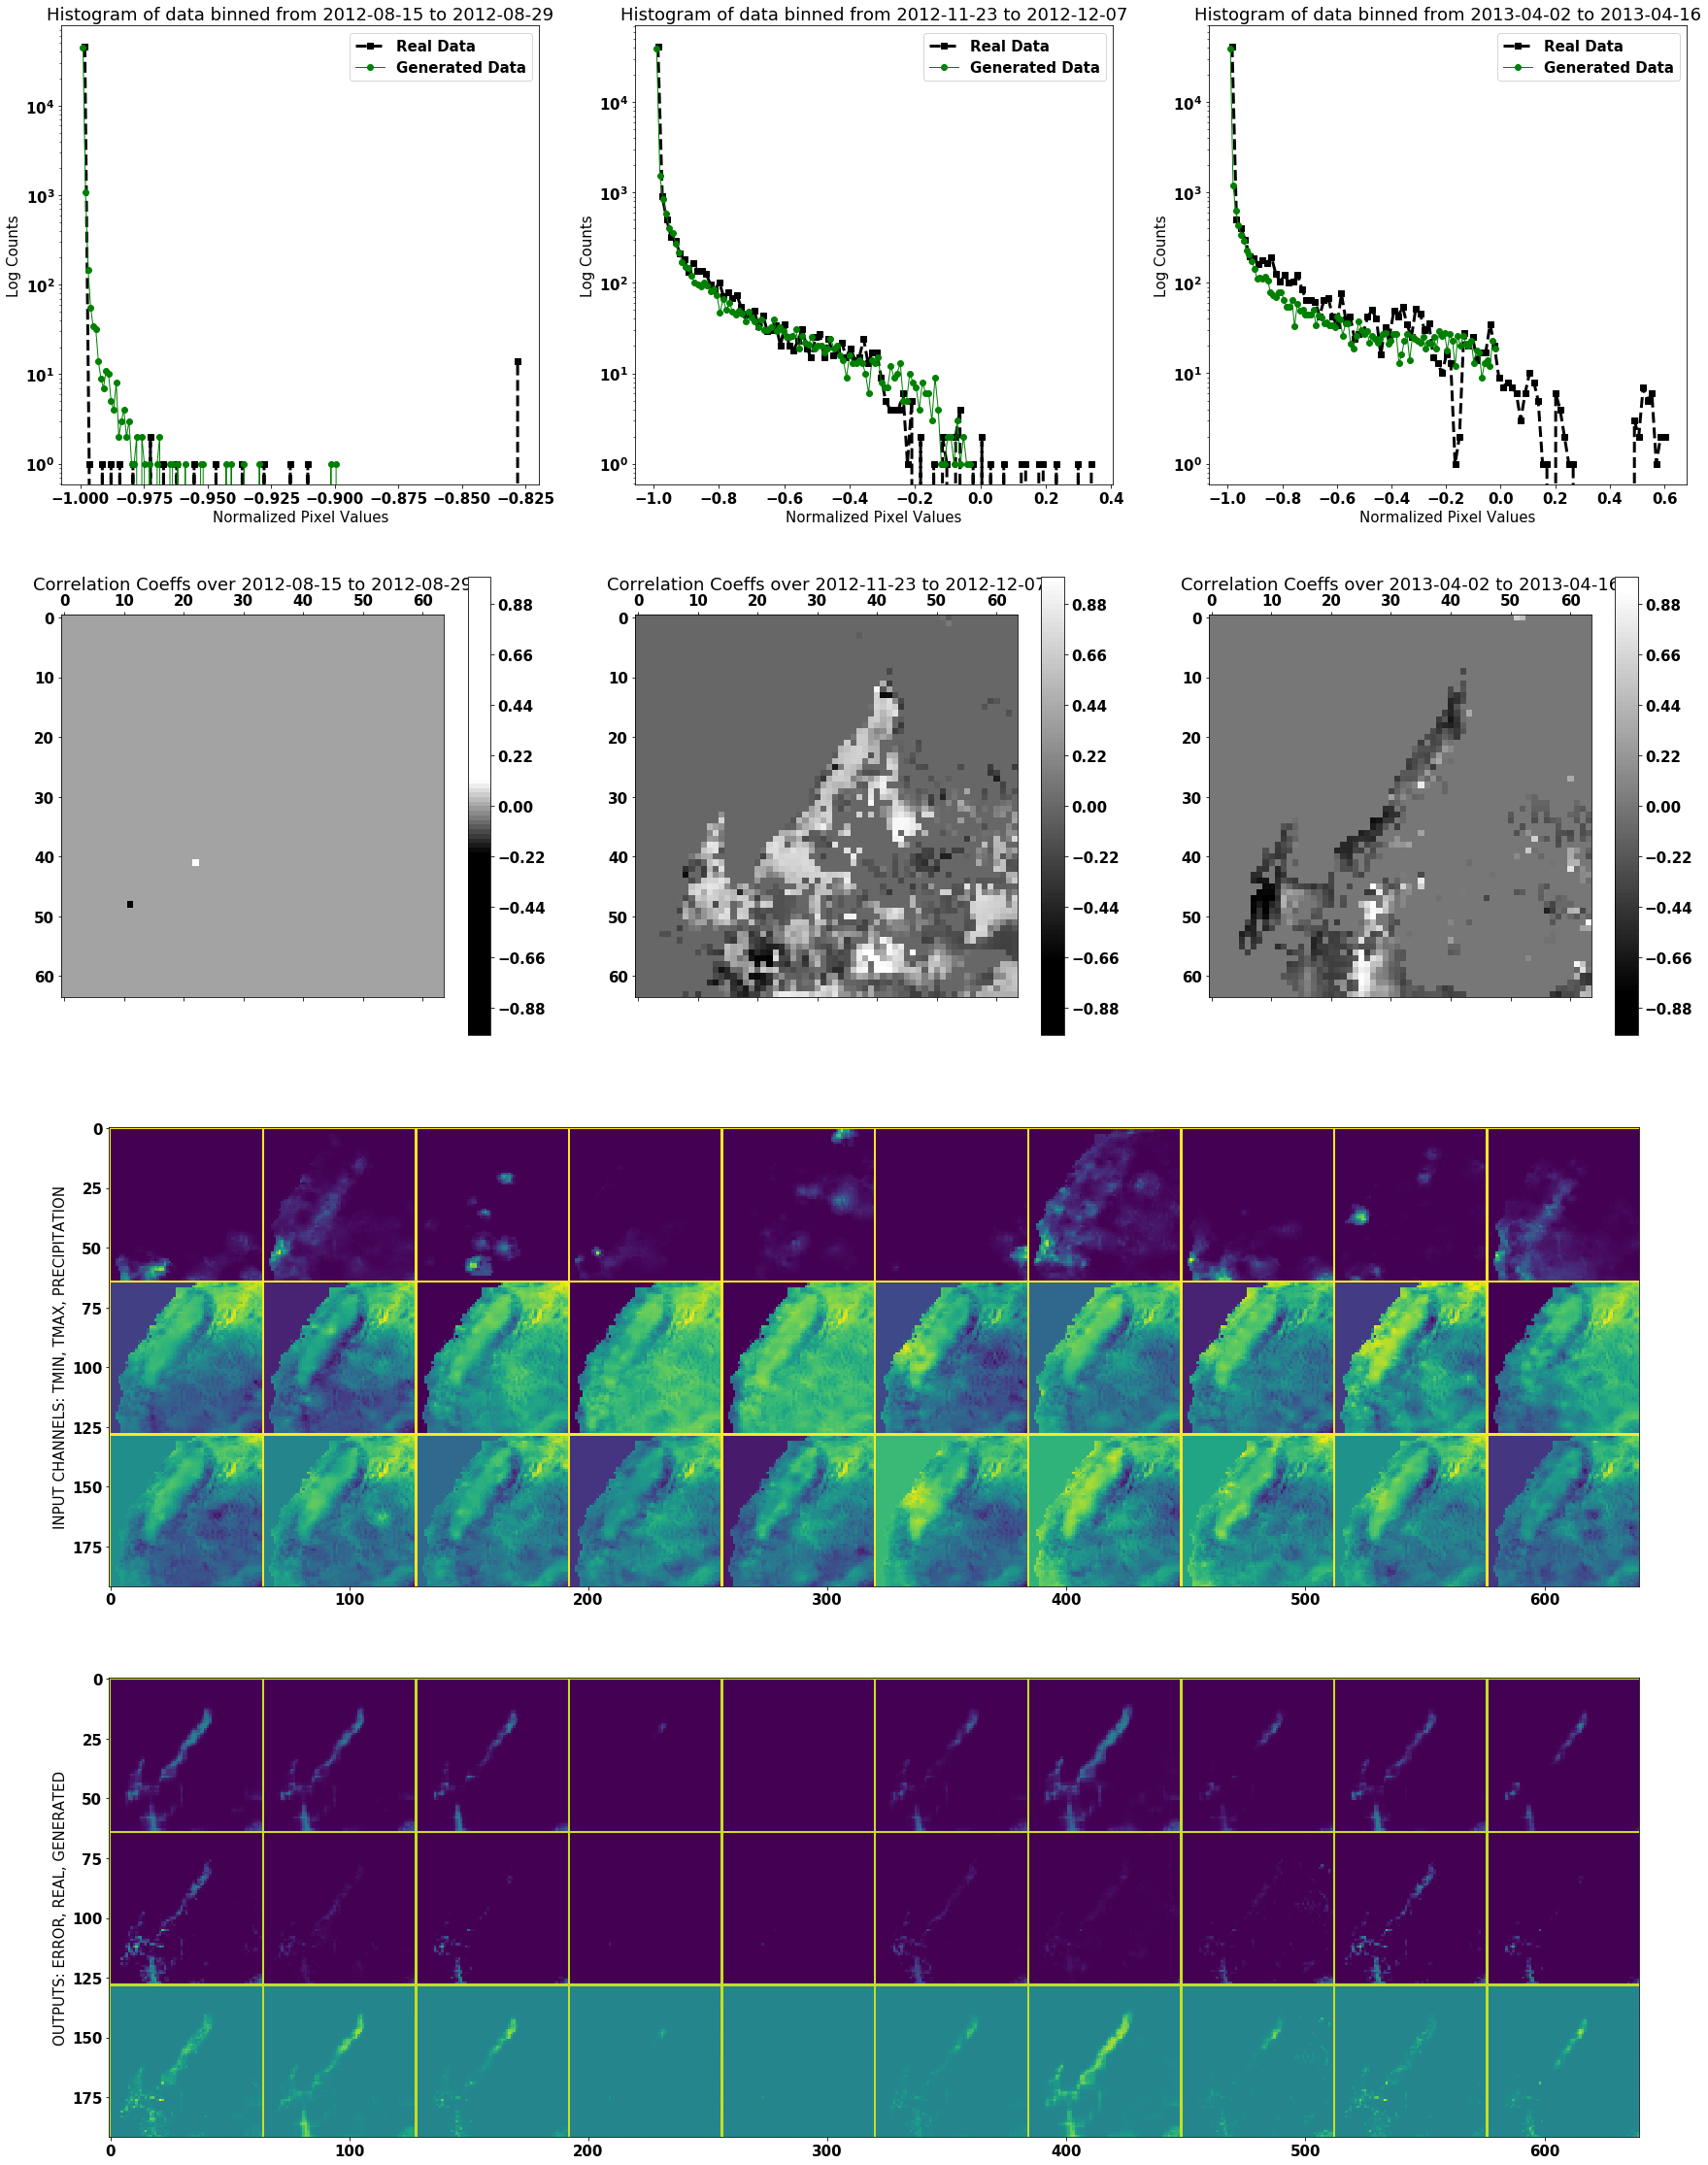

In [63]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


nov_aug_apr_hist(data_A, data_B, mask)